In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
from dotenv import load_dotenv
import psycopg2
from sqlalchemy import create_engine

# Load data

In [2]:
# Load data from sql
def load_data(query: str) -> pd.DataFrame:
    # Load environment variables from .env file
    env_path = os.path.join("..", ".env")
    load_dotenv(dotenv_path=env_path)

    # Retrieve database connection parameters
    DB_USER = os.getenv("DB_USER")
    DB_PASSWORD = os.getenv("DB_PASSWORD")
    DB_HOST = os.getenv("DB_HOST")
    DB_PORT = os.getenv("DB_PORT")
    DB_NAME = os.getenv("DB_NAME")

    # Use psycopg2 directly
    conn = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD
    )
    
    try:
        df = pd.read_sql_query(query, conn)
        return df
    finally:
        conn.close()
    
# Example usage
query = "SELECT * FROM raw.pharmacy_sales;"

In [3]:
pd.set_option('display.max_columns', None)
df = load_data(query=query)
df.head()

,distributor,customer_name,city,country,latitude,longitude,channel,sub_channel,product_name,product_class,quantity,price,sales,month,year,sales_rep_name,manager,sales_team
0,Gottlieb-Cruickshank,"Zieme, Doyle and Kunze",Lublin,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368.0,1472.0,January,2018,Mary Gerrard,Britanny Bold,Delta
1,Gottlieb-Cruickshank,Feest PLC,Świecie,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591.0,4137.0,January,2018,Jessica Smith,Britanny Bold,Delta
2,Gottlieb-Cruickshank,Medhurst-Beer Pharmaceutical Limited,Rybnik,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66.0,1980.0,January,2018,Steve Pepple,Tracy Banks,Bravo
3,Gottlieb-Cruickshank,Barton Ltd Pharma Plc,Czeladź,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435.0,2610.0,January,2018,Mary Gerrard,Britanny Bold,Delta
4,Gottlieb-Cruickshank,Keeling LLC Pharmacy,Olsztyn,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458.0,9160.0,January,2018,Anne Wu,Britanny Bold,Delta


# Feature Engineering

In [4]:
# Map month from names to numbers
def month_mapping(df):
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df['month'] = df['month'].map(month_map)
    return df
df = month_mapping(df)

In [5]:
df.head()

,distributor,customer_name,city,country,latitude,longitude,channel,sub_channel,product_name,product_class,quantity,price,sales,month,year,sales_rep_name,manager,sales_team
0,Gottlieb-Cruickshank,"Zieme, Doyle and Kunze",Lublin,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368.0,1472.0,1,2018,Mary Gerrard,Britanny Bold,Delta
1,Gottlieb-Cruickshank,Feest PLC,Świecie,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591.0,4137.0,1,2018,Jessica Smith,Britanny Bold,Delta
2,Gottlieb-Cruickshank,Medhurst-Beer Pharmaceutical Limited,Rybnik,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66.0,1980.0,1,2018,Steve Pepple,Tracy Banks,Bravo
3,Gottlieb-Cruickshank,Barton Ltd Pharma Plc,Czeladź,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435.0,2610.0,1,2018,Mary Gerrard,Britanny Bold,Delta
4,Gottlieb-Cruickshank,Keeling LLC Pharmacy,Olsztyn,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458.0,9160.0,1,2018,Anne Wu,Britanny Bold,Delta


# Data Visualization

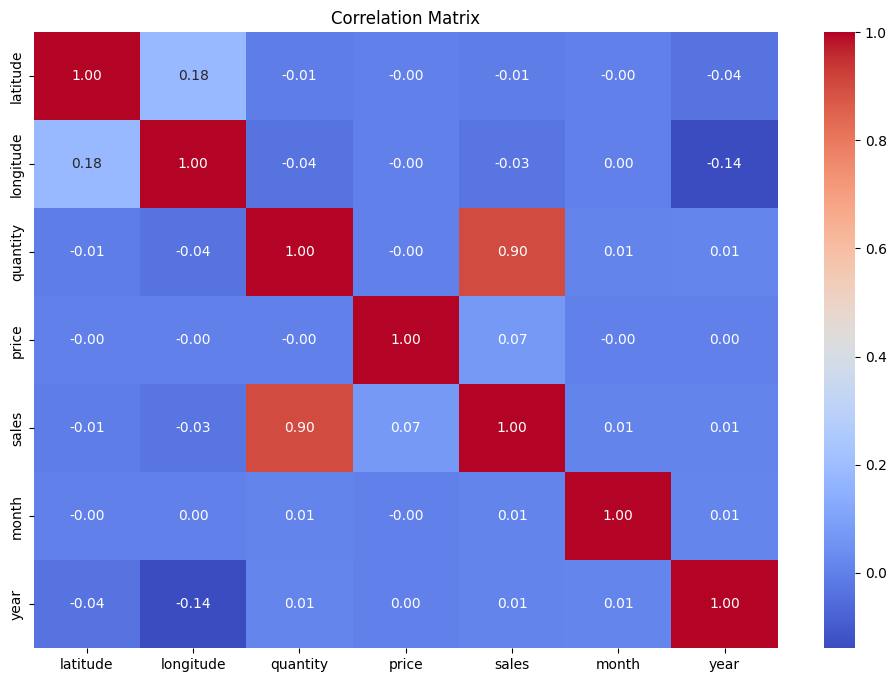

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

corr = df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

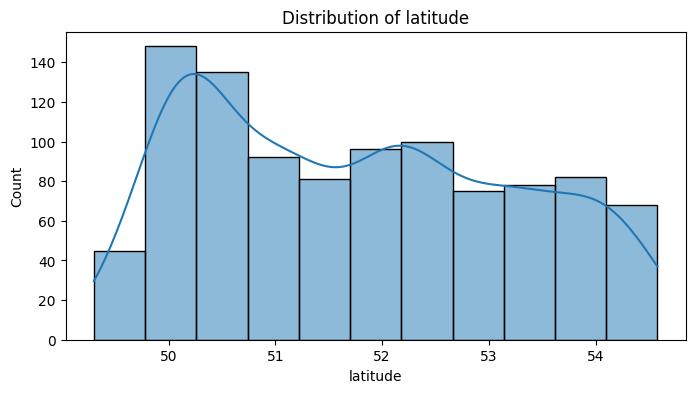

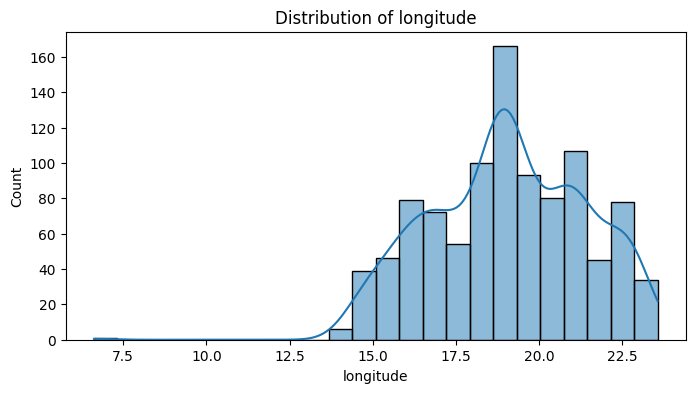

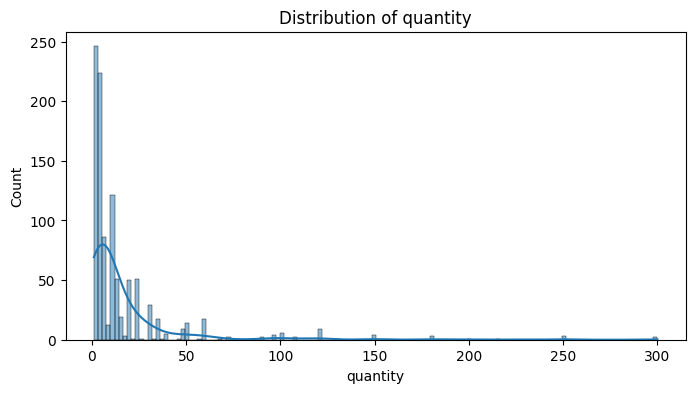

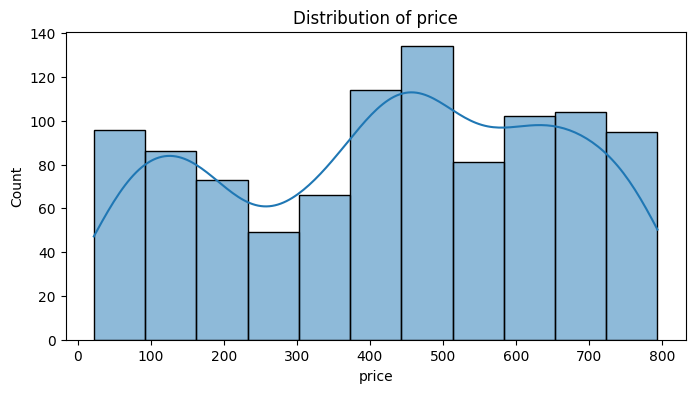

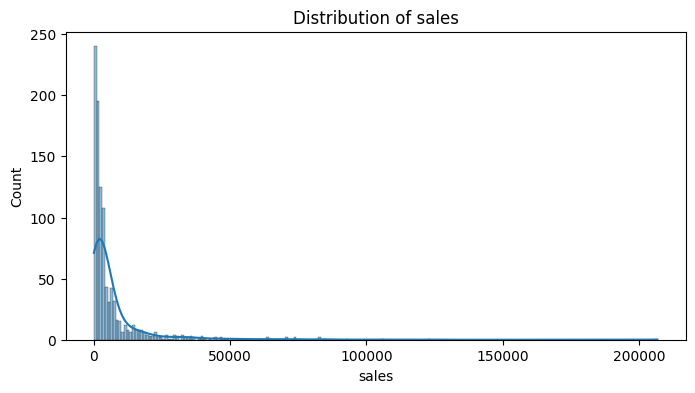

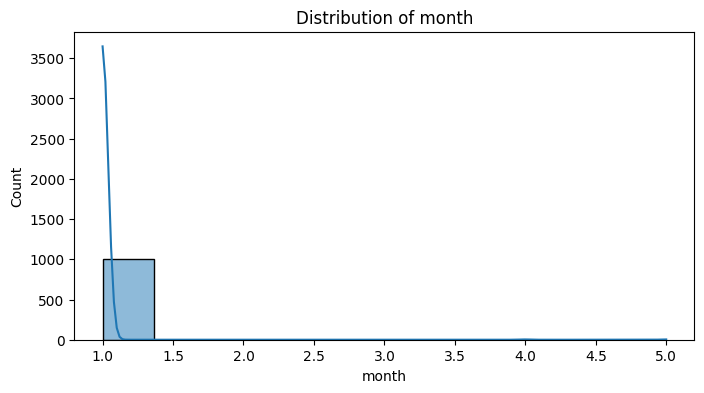

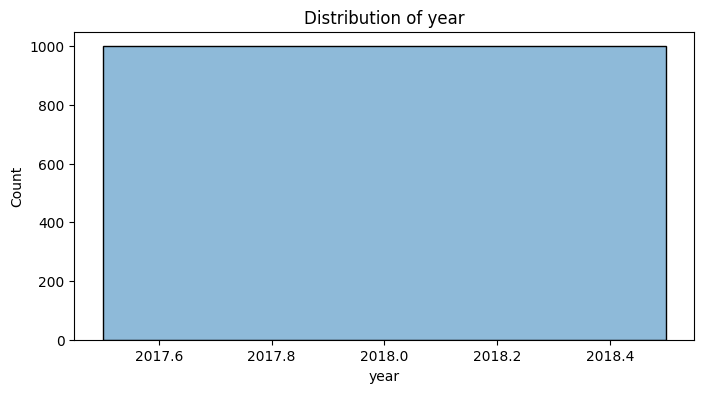

In [7]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].head(1000), kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

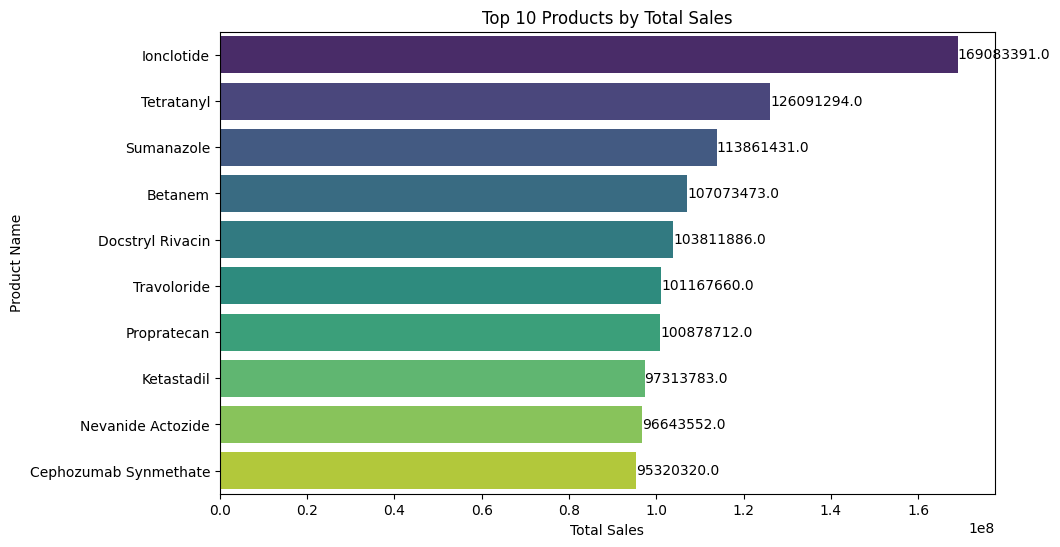

In [8]:
# Top 10 product by total sales
top_products = df.groupby('product_name')['sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
for i, v in enumerate(top_products.values):
    plt.text(v + 0.01, i, str(round(v, 2)), color='black', va='center')
plt.show()

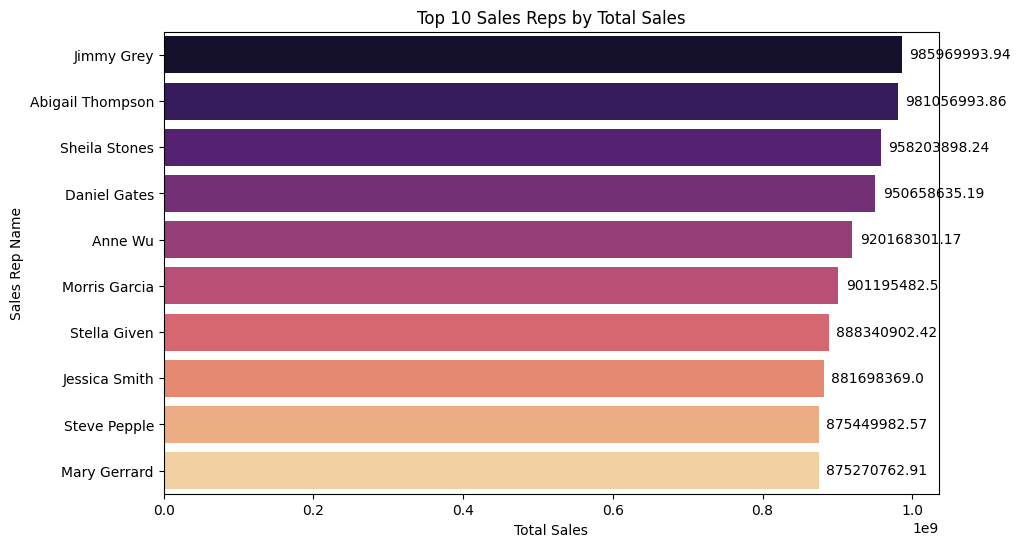

In [9]:
# Top 10 sales rep by total sales
top_sales_reps = df.groupby('sales_rep_name')['sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_sales_reps.values, y=top_sales_reps.index, palette='magma')
plt.title('Top 10 Sales Reps by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Sales Rep Name')
# Add data labels
for i, v in enumerate(top_sales_reps.values):
    plt.text(v + 0.01 * max(top_sales_reps.values), i, str(round(v, 2)), color='black', va='center')
plt.show()

In [10]:
df.head()

,distributor,customer_name,city,country,latitude,longitude,channel,sub_channel,product_name,product_class,quantity,price,sales,month,year,sales_rep_name,manager,sales_team
0,Gottlieb-Cruickshank,"Zieme, Doyle and Kunze",Lublin,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368.0,1472.0,1,2018,Mary Gerrard,Britanny Bold,Delta
1,Gottlieb-Cruickshank,Feest PLC,Świecie,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591.0,4137.0,1,2018,Jessica Smith,Britanny Bold,Delta
2,Gottlieb-Cruickshank,Medhurst-Beer Pharmaceutical Limited,Rybnik,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66.0,1980.0,1,2018,Steve Pepple,Tracy Banks,Bravo
3,Gottlieb-Cruickshank,Barton Ltd Pharma Plc,Czeladź,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435.0,2610.0,1,2018,Mary Gerrard,Britanny Bold,Delta
4,Gottlieb-Cruickshank,Keeling LLC Pharmacy,Olsztyn,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458.0,9160.0,1,2018,Anne Wu,Britanny Bold,Delta


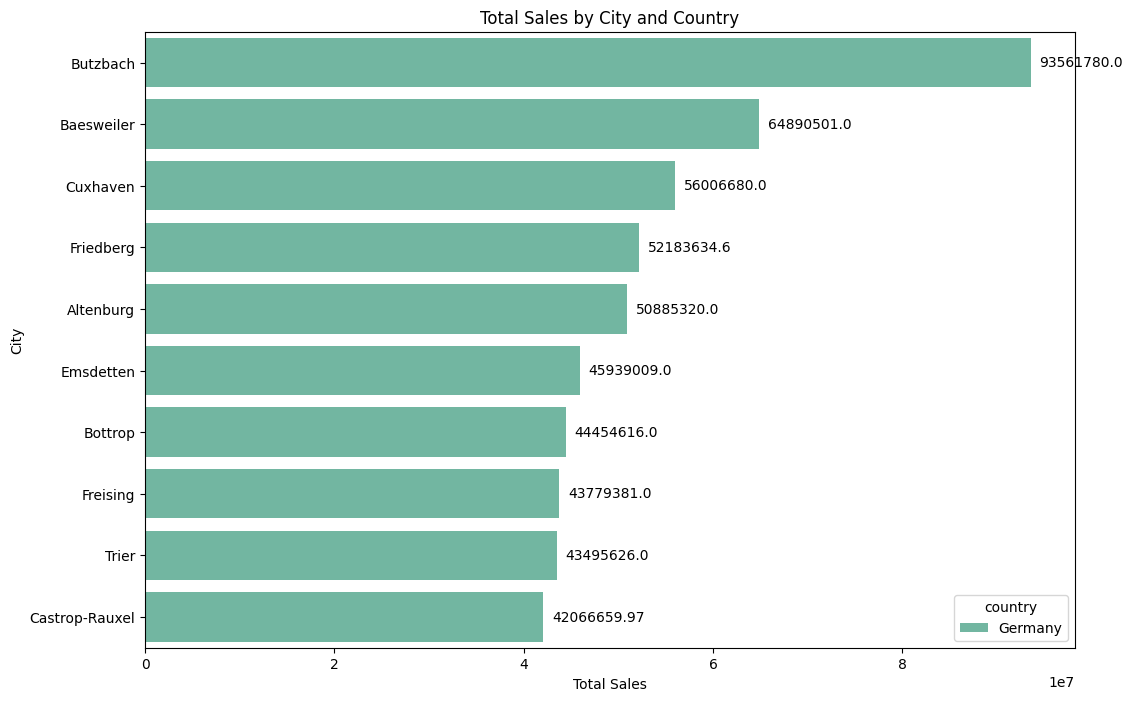

In [11]:
# Distribution of sales by city, country
region_sales = df.groupby(['country', 'city'])['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=region_sales, x='sales', y='city', hue='country', dodge=False, palette='Set2')
plt.title('Total Sales by City and Country')
plt.xlabel('Total Sales')
plt.ylabel('City')
for i, v in enumerate(region_sales['sales']):
    plt.text(v + 0.01 * max(region_sales['sales']), i, str(round(v, 2)), color='black', va='center')
plt.show()

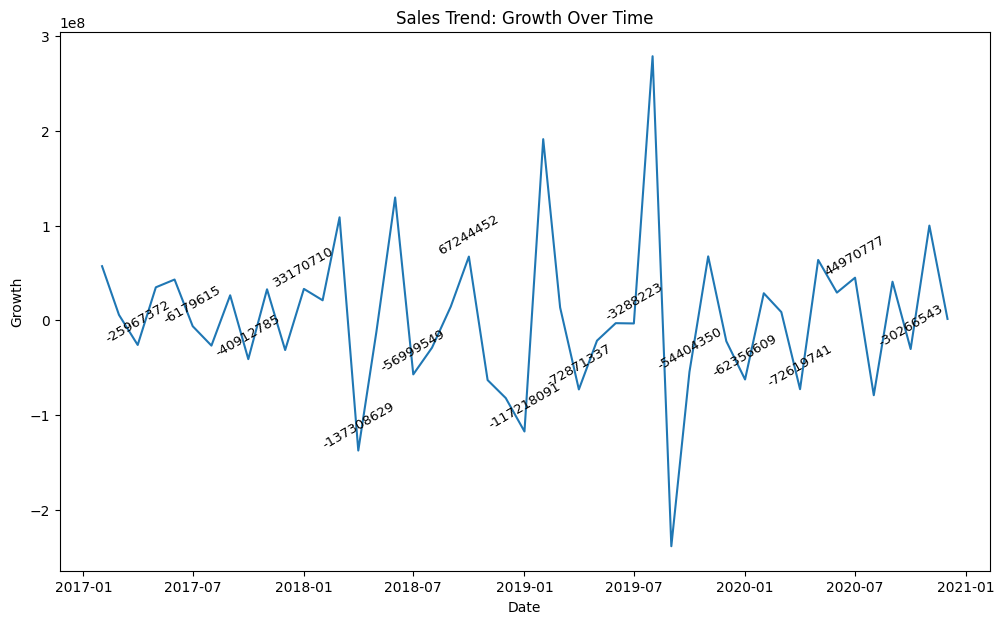

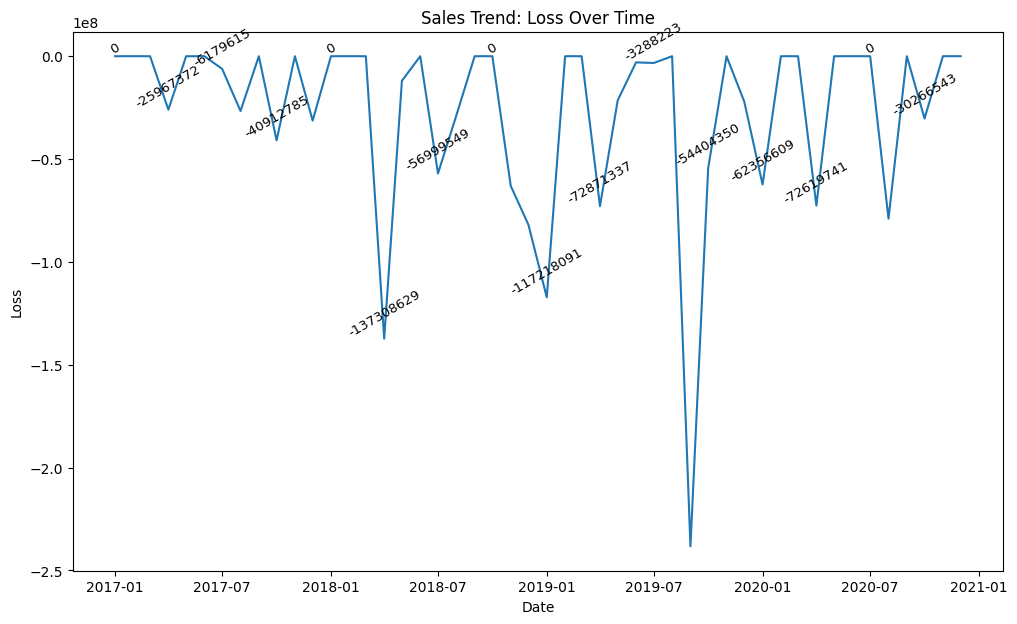

In [12]:
# Function for count agregation sales trend (sum, mean, meadian, growth, loss)

def sales_trend_analysis(df):
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str), format='%Y-%m')
    trend = df.groupby('date')['sales'].agg(['sum', 'mean', 'median']).reset_index()
    trend['growth'] = trend['sum'].diff()
    trend['loss'] = trend['growth'].apply(lambda x: x if x < 0 else 0)
    return trend

# usage and visualize
sales_trend = sales_trend_analysis(df)

for col in ['growth', 'loss']: # we can modified to call other columns like sum, mean, median
    plt.figure(figsize=(12, 7))
    ax = sns.lineplot(data=sales_trend, x='date', y=col)
    plt.title(f'Sales Trend: {col.capitalize()} Over Time')
    plt.xlabel('Date')
    plt.ylabel(col.capitalize())
    # only show annotation on every 3rd month point
    for i, (x, y) in enumerate(zip(sales_trend['date'], sales_trend[col])):
        if i % 3 == 0: # show per trimester
            plt.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=9.5, color='black', rotation=30)
    plt.show()

# Feature Engineering

In [13]:
# Data preprocessing to add more features like sales_growth_pct, rolling_avg_3m, lag_1_month, sales_volatility, 
def feature_engineering(df):
    df = df.sort_values(by=['product_name', 'year', 'month'])
    
    # Sales Growth Percentage
    df['sales_growth_pct'] = df.groupby('product_name')['sales'].pct_change()

    # 3-Month Rolling Average
    df['rolling_avg_3m'] = (df.groupby('product_name')['sales']
                            .rolling(window=3, min_periods=1)
                            .mean()
                            .reset_index(level=0, drop=True))

    # lag feature 1 month
    df['lag_1_month'] = df.groupby('product_name')['sales'].shift(1)

    # Sales Volatility (Standard Deviation over past 3 months)
    df['sales_volatility'] = df.groupby('product_name')['sales'].transform(lambda x: x.rolling(window=3).std())

    # Sales normalized by Price
    df['sales_clean'] = df['sales'].clip(lower=0) # don't include negative sales values
    df['sales_zscore_price'] = ((df['sales_clean'] - df['sales_clean'].mean()) / df['sales_clean'].std())

    return df

df = feature_engineering(df)

In [14]:
# Handle missing values in the new features
def fill_missing_values(df):
    df['sales_growth_pct'] = df['sales_growth_pct'].fillna(df['sales_growth_pct'].median()).round(2)
    df['rolling_avg_3m'] = df['rolling_avg_3m'].fillna(df['rolling_avg_3m'].median()).round(2)
    df['lag_1_month'] = df['lag_1_month'].fillna(df['lag_1_month'].median()).round(2)
    df['sales_volatility'] = df['sales_volatility'].fillna(df['sales_volatility'].median()).round(2)
    return df

df = fill_missing_values(df)

# Data Encoding

In [15]:
# data encoding
from sklearn.preprocessing import LabelEncoder

df_clean = df.copy() # make a copy to preserve original data

# Encode categorical variables
le = LabelEncoder()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

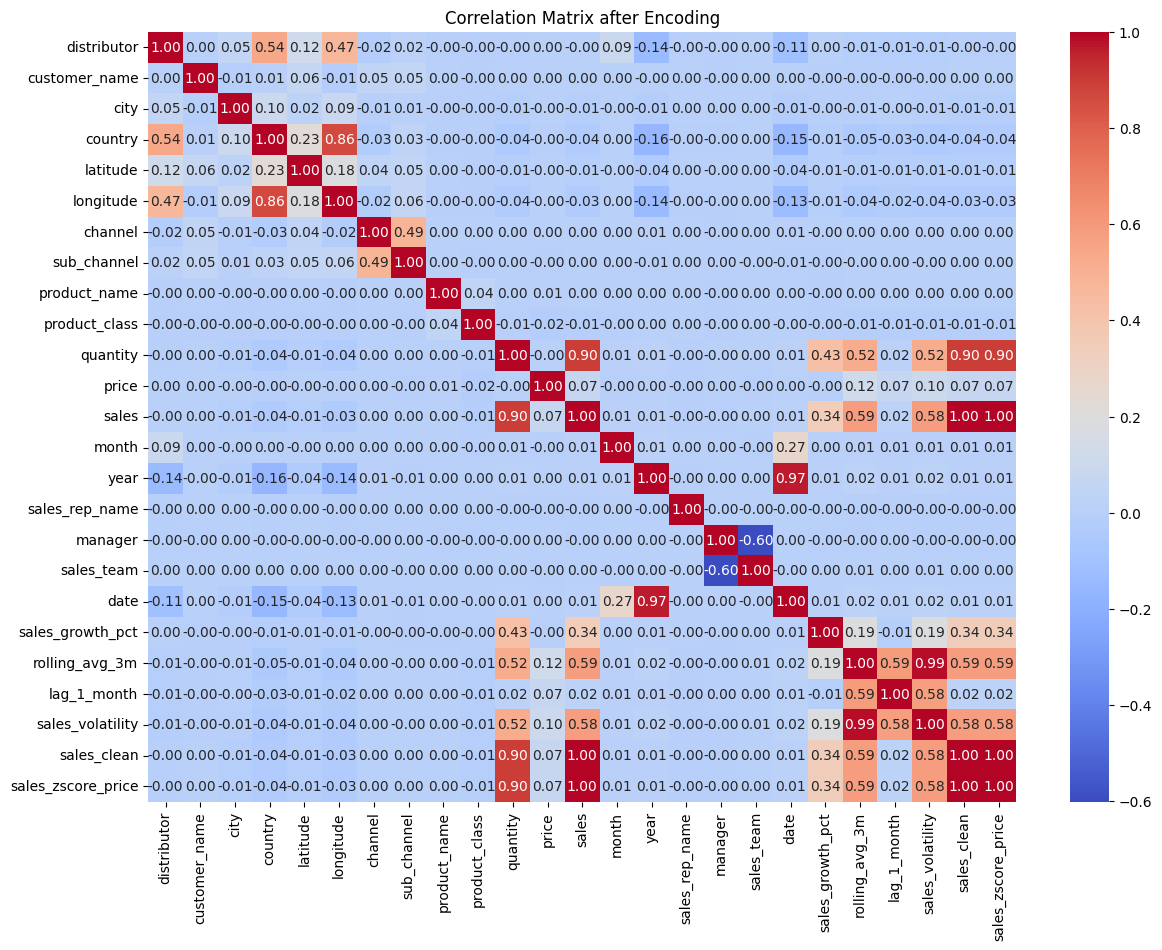

In [16]:
# Correlation matrix after encoding and cleaning
df_clean.corr()

# plotting
plt.figure(figsize=(14, 10))
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix after Encoding')
plt.show()

# Split data X and y

In [17]:
TARGET = "sales"
FEATURES = [col for col in df_clean.columns if col != TARGET and col not in ['date']]

X = df_clean[FEATURES]
y = df_clean[TARGET]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (203265, 23)
X_test shape: (50817, 23)
y_train shape: (203265,)
y_test shape: (50817,)


In [22]:
FEATURES

['distributor',
 'customer_name',
 'city',
 'country',
 'latitude',
 'longitude',
 'channel',
 'sub_channel',
 'product_name',
 'product_class',
 'quantity',
 'price',
 'month',
 'year',
 'sales_rep_name',
 'manager',
 'sales_team',
 'sales_growth_pct',
 'rolling_avg_3m',
 'lag_1_month',
 'sales_volatility',
 'sales_clean',
 'sales_zscore_price']

In [18]:
pd.DataFrame(df_clean['sales'])

,sales
40588,3710.0
41190,7420.0
41447,14840.0
41861,3710.0
41875,17808.0
...,...
253216,64600.0
253271,2584.0
253301,96900.0
253331,71060.0


# Machine learning models

In [19]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor

def build_base_models(random_state: int = 42) -> dict:
    """Build base machine learning models."""
    return {
        "LinearRegression": LinearRegression(),
        "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1),
        "CatBoostRegressor": CatBoostRegressor(verbose=0, random_state=random_state)
    }

In [20]:
def build_voting_regressor(models: dict, weights: list | None = None) -> VotingRegressor:
    """Build a Voting Regressor from base models."""
    estimators = [(name, model) for name, model in models.items()]

    return VotingRegressor(
        estimators=estimators,
        weights=weights
    )

# Build training function
def train_model(model, X_train, y_train):
    """Train the given model with training data."""
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test) -> dict:
    """Evaluate the model and return performance metrics."""
    y_pred = model.predict(X_test)
    
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred)
    }


In [21]:
# Build models
models = build_base_models()

# Build Voting Regressor
voting_model = build_voting_regressor(models=models,
                                      weights=[1, 2, 3])

# Clean X_train and X_test from infinity and NaN before training
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median()).clip(-1e10, 1e10)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_test.median()).clip(-1e10, 1e10)

# Train Voting Regressor
voting_model = train_model(model=voting_model,
                           X_train=X_train,
                           y_train=y_train)

# Evaluate Voting Regressor
metrics = evaluate_model(model=voting_model,
                         X_test=X_test,
                         y_test=y_test)

KeyboardInterrupt: 

# See values whos good models values and good metrics

In [ ]:
# See values whos good models values and good metrics

for model_name, model in models.items():
    model = train_model(model=model, X_train=X_train, y_train=y_train)
    model_metrics = evaluate_model(model=model, X_test=X_test, y_test=y_test)
    print(f"Model: {model_name}")
    print(f"Metrics: {model_metrics}")

Model: LinearRegression
Metrics: {'MAE': 3114.6289030351613, 'MSE': 204286497.06105426, 'R2': 0.9969295228094635, 'MAPE': 383359110384854.44}
Model: RandomForestRegressor
Metrics: {'MAE': 120.84349100722224, 'MSE': 39163032.526394755, 'R2': 0.9994113698173179, 'MAPE': 148179124642.61133}
Model: CatBoostRegressor
Metrics: {'MAE': 2756.8710794665344, 'MSE': 3578903366.7236495, 'R2': 0.9462081864795253, 'MAPE': 1079037788502263.0}


In [ ]:
# Table of model metrics
model_performance = []
for model_name, model in models.items():
    model = train_model(model=model, X_train=X_train, y_train=y_train)
    y_pred = model.predict(X_test)
    model_metrics = evaluate_model(model=model, X_test=X_test, y_test=y_test)
    model_performance.append({
        "Model": model_name,
        **model_metrics
    })
model_performance = pd.DataFrame(model_performance)
model_performance.sort_values(by='R2', ascending=False)

,Model,MAE,MSE,R2,MAPE
1,RandomForestRegressor,120.843491,3.916303e+07,0.999411,1.481791e+11
0,LinearRegression,3114.628903,2.042865e+08,0.996930,3.833591e+14
2,CatBoostRegressor,2756.871079,3.578903e+09,0.946208,1.079038e+15


# Save models

# Load models

# Data visualization insights after modeling

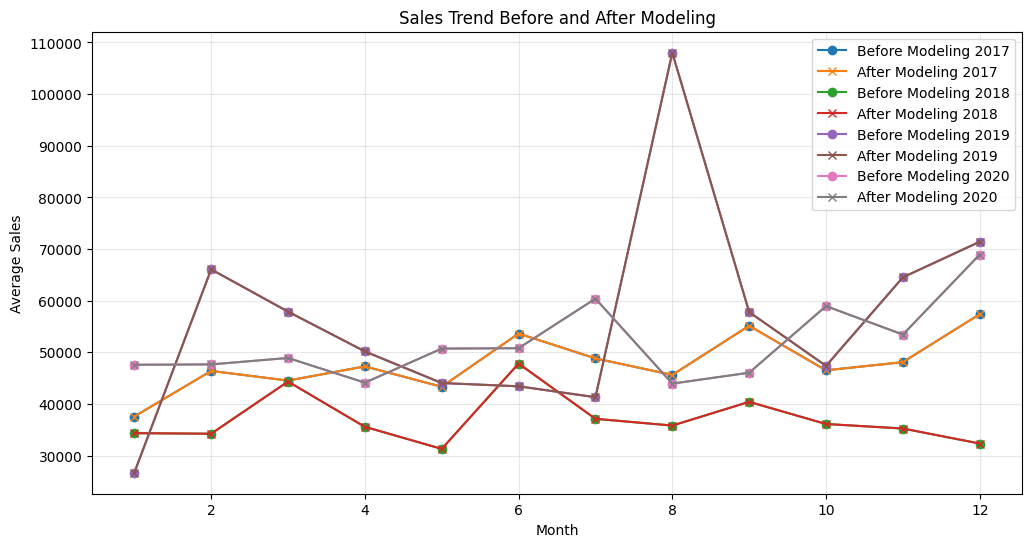

In [ ]:
# Compare sales trends before and after modeling
df_trend_before = df.groupby(['year', 'month'])['sales'].mean().reset_index()
df_trend_after = df_clean.groupby(['year', 'month'])['sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
for year in df_trend_before['year'].unique():
    df_year_before = df_trend_before[df_trend_before['year'] == year]
    df_year_after = df_trend_after[df_trend_after['year'] == year]

    plt.plot(df_year_before['month'], df_year_before['sales'], marker='o', label=f'Before Modeling {year}')
    plt.plot(df_year_after['month'], df_year_after['sales'], marker='x', label=f'After Modeling {year}')

plt.title('Sales Trend Before and After Modeling')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# MLflow Tracking

In [ ]:
import mlflow
import mlflow.sklearn
import os

# PostgreSQL as backend store
def load_env_variables():
    # Load environment variables from .env file
    env_path = os.path.join("..", ".env")
    load_dotenv(dotenv_path=env_path)

    # Retrieve database connection parameters from environment variables
    DB_USER = os.getenv("DB_USER")
    DB_PASSWORD = os.getenv("DB_PASSWORD")
    DB_HOST = os.getenv("DB_HOST")
    DB_PORT = os.getenv("DB_PORT")
    DB_NAME = os.getenv("DB_NAME")
    
    return DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME
DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME = load_env_variables()

# Set MLflow tracking URI to PostgreSQL
mlflow.set_tracking_uri(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Atrtifact store to local directory
os.environ["MLFLOW_ARTIFACT_ROOT"] = os.path.join(os.getcwd(), "mlruns")

with mlflow.start_run(run_name="voting_regressor_pharma_sales") as run:
    # Log model
    mlflow.sklearn.log_model(voting_model, artifact_path="voting_regressor_model", registered_model_name=None)

    # Log parameters
    mlflow.log_param("model_type", "VotingRegressor")
    mlflow.log_param("base_models", list(models.keys()))
    mlflow.log_param("weights", [1, 2, 3])

    # Log metrics
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)

    run_id = run.info.run_id
    print(f"Run ID: {run_id}")


Run ID: eb56e25fdebd48bdb360bc4b996d2f37
